In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [2]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv('ETH-USD.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [7]:
# Hàm tạo đặc trưng lag
def create_lagged_features(data, n_lags=1):
    df_lags = pd.DataFrame()
    for i in range(n_lags):
        df_lags[f'lag_{i+1}'] = np.roll(data, shift=i+1)
    df_lags['target'] = data
    return df_lags.iloc[n_lags:]

In [8]:
# Hàm tối ưu hóa sử dụng Optuna
def objective(trial):
    # Gợi ý giá trị cho n_lags và n_estimators
    n_lags = trial.suggest_int('n_lags', 1, 30)                 # Tìm số lượng lag từ 1 đến 30
    n_estimators = trial.suggest_int('n_estimators', 10, 200)   # Tìm số lượng cây từ 10 đến 200

    # Tạo đặc trưng lag
    lagged_data = create_lagged_features(data_scaled.flatten(), n_lags)
    X, y = lagged_data.iloc[:, :-1], lagged_data.iloc[:, -1]

    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        errors.append(mean_squared_error(y_test, y_pred))

    return np.mean(errors)

**Tìm kiếm tham số tối ưu**

In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần để tìm giá trị tối ưu

# In ra tham số tối ưu
best_params = study.best_params
print(f'Best parameters: {best_params}')
print(f'Best trial value: {study.best_value}')


[I 2024-06-13 09:18:54,641] A new study created in memory with name: no-name-d961a836-2b87-4120-8bed-163e8d53bccb
[I 2024-06-13 09:18:55,185] Trial 0 finished with value: 0.03382717575423656 and parameters: {'n_lags': 3, 'n_estimators': 29}. Best is trial 0 with value: 0.03382717575423656.
[I 2024-06-13 09:19:00,449] Trial 1 finished with value: 0.03614918407218987 and parameters: {'n_lags': 26, 'n_estimators': 67}. Best is trial 0 with value: 0.03382717575423656.
[I 2024-06-13 09:19:06,319] Trial 2 finished with value: 0.03379570602831347 and parameters: {'n_lags': 2, 'n_estimators': 193}. Best is trial 2 with value: 0.03379570602831347.
[I 2024-06-13 09:19:11,497] Trial 3 finished with value: 0.03494296927505389 and parameters: {'n_lags': 8, 'n_estimators': 166}. Best is trial 2 with value: 0.03379570602831347.
[I 2024-06-13 09:19:15,699] Trial 4 finished with value: 0.0371115377818078 and parameters: {'n_lags': 23, 'n_estimators': 57}. Best is trial 2 with value: 0.03379570602831347

Best parameters: {'n_lags': 1, 'n_estimators': 191}
Best trial value: 0.03345090663928777


**Sử dụng tham số tối ưu để huấn luyện mô hình cuối cùng**

In [10]:
optimal_n_lags = best_params['n_lags']
optimal_n_estimators = best_params['n_estimators']
lagged_data = create_lagged_features(data_scaled.flatten(), optimal_n_lags)

In [11]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.9 * len(lagged_data))
train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]
# Tách các đặc trưng và mục tiêu
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [12]:
# Huấn luyện mô hình Random Forest với các tham số tối ưu
rf_model = RandomForestRegressor(n_estimators=optimal_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=191, random_state=42)

In [13]:
# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

In [14]:
# Chuyển đổi lại dữ liệu về thang đo gốc
y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [15]:
# Tính toán các độ đo lỗi
test_mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
test_mse = mean_squared_error(y_test_inverse, y_pred_inverse)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape:.4f}")
print(f"RMSE on Test dataset: {test_rmse:.4f}")
print(f"MSE on Test dataset: {test_mse:.4f}")

MAPE on Test dataset: 0.0359
RMSE on Test dataset: 140.8226
MSE on Test dataset: 19831.0122


In [16]:
# Hàm dự báo tương lai
def forecast_future(model, data, n_lags, n_periods):
    future_forecast = []
    last_values = data[-n_lags:]
    for _ in range(n_periods):
        prediction = model.predict(last_values.reshape(1, -1))[0]
        future_forecast.append(prediction)
        last_values = np.append(last_values[1:], prediction)
    return np.array(future_forecast)

In [17]:
# Dự báo giá trị tương lai
forecast_30_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 30)
forecast_60_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 60)
forecast_90_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 90)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

In [18]:
# Chuyển đổi dự báo về thang đo gốc
forecast_30_days_inverse = scaler.inverse_transform(forecast_30_days.reshape(-1, 1))
forecast_60_days_inverse = scaler.inverse_transform(forecast_60_days.reshape(-1, 1))
forecast_90_days_inverse = scaler.inverse_transform(forecast_90_days.reshape(-1, 1))

In [19]:
print('Predicted closing prices for the next 30 days:')
print(forecast_30_days_inverse.flatten())

print('Predicted closing prices for the next 60 days:')
print(forecast_60_days_inverse.flatten())

print('Predicted closing prices for the next 90 days:')
print(forecast_90_days_inverse.flatten())

Predicted closing prices for the next 30 days:
[3684.00775476 3772.79896084 3814.40773514 3684.00775476 3772.79896084
 3814.40773514 3684.00775476 3772.79896084 3814.40773514 3684.00775476
 3772.79896084 3814.40773514 3684.00775476 3772.79896084 3814.40773514
 3684.00775476 3772.79896084 3814.40773514 3684.00775476 3772.79896084
 3814.40773514 3684.00775476 3772.79896084 3814.40773514 3684.00775476
 3772.79896084 3814.40773514 3684.00775476 3772.79896084 3814.40773514]
Predicted closing prices for the next 60 days:
[3684.00775476 3772.79896084 3814.40773514 3684.00775476 3772.79896084
 3814.40773514 3684.00775476 3772.79896084 3814.40773514 3684.00775476
 3772.79896084 3814.40773514 3684.00775476 3772.79896084 3814.40773514
 3684.00775476 3772.79896084 3814.40773514 3684.00775476 3772.79896084
 3814.40773514 3684.00775476 3772.79896084 3814.40773514 3684.00775476
 3772.79896084 3814.40773514 3684.00775476 3772.79896084 3814.40773514
 3684.00775476 3772.79896084 3814.40773514 3684.00775

In [20]:
# Tạo index cho các dự đoán tiếp theo
last_date = df.index[-1]
index_next_30_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=30, freq='D')
index_next_60_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=60, freq='D')
index_next_90_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=90, freq='D')

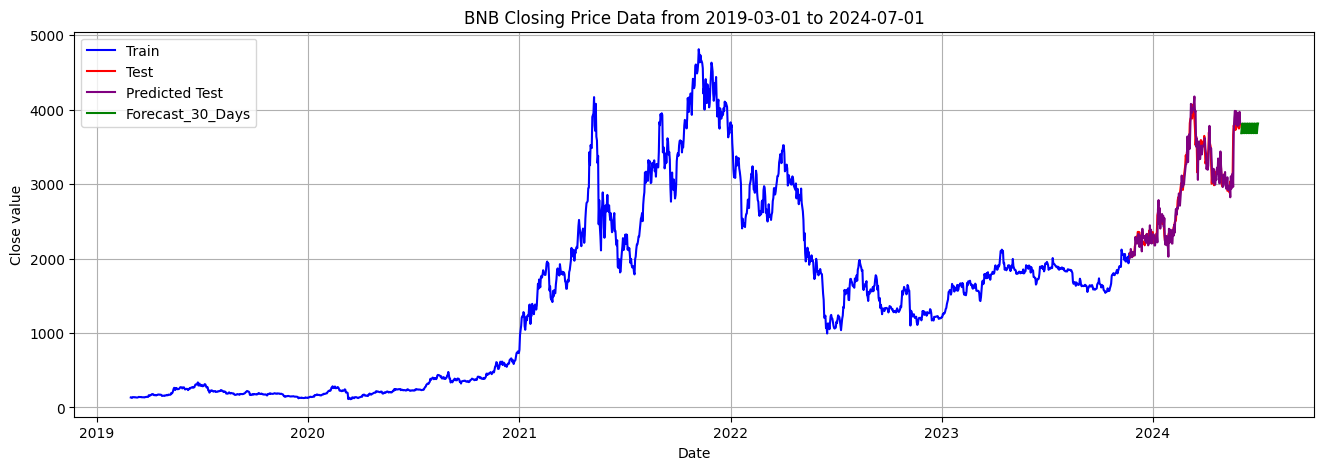

In [21]:
# Vẽ đồ thị cho dự đoán 30 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_30_days, forecast_30_days_inverse, color='green', linestyle='-', label='Forecast_30_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_ETH_30days_91.png')
plt.show()


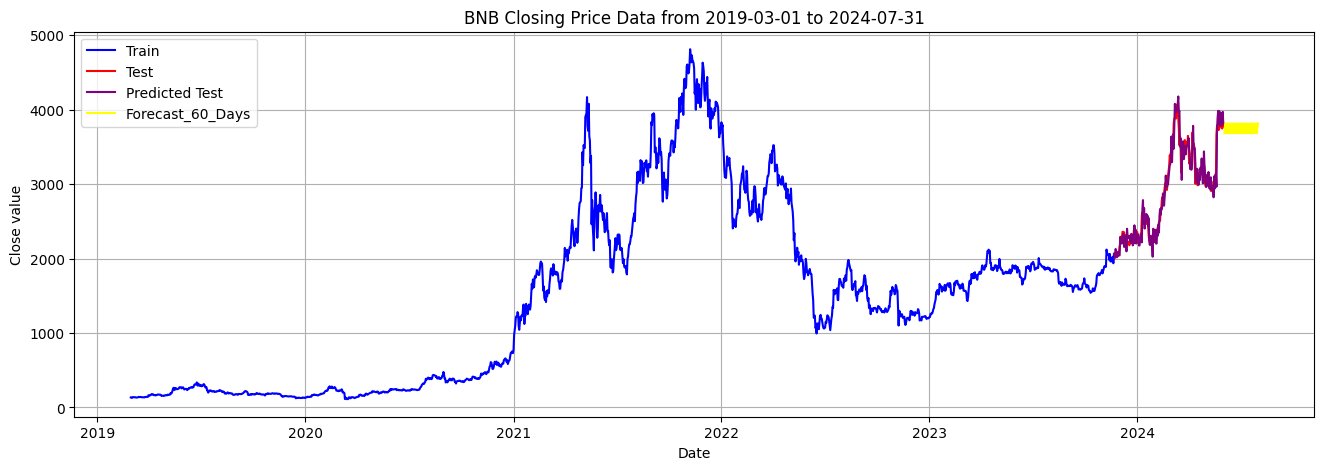

In [22]:
# Vẽ đồ thị cho dự đoán 60 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_60_days, forecast_60_days_inverse, color='yellow', linestyle='-', label='Forecast_60_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_ETH_60days_91.png')
plt.show()


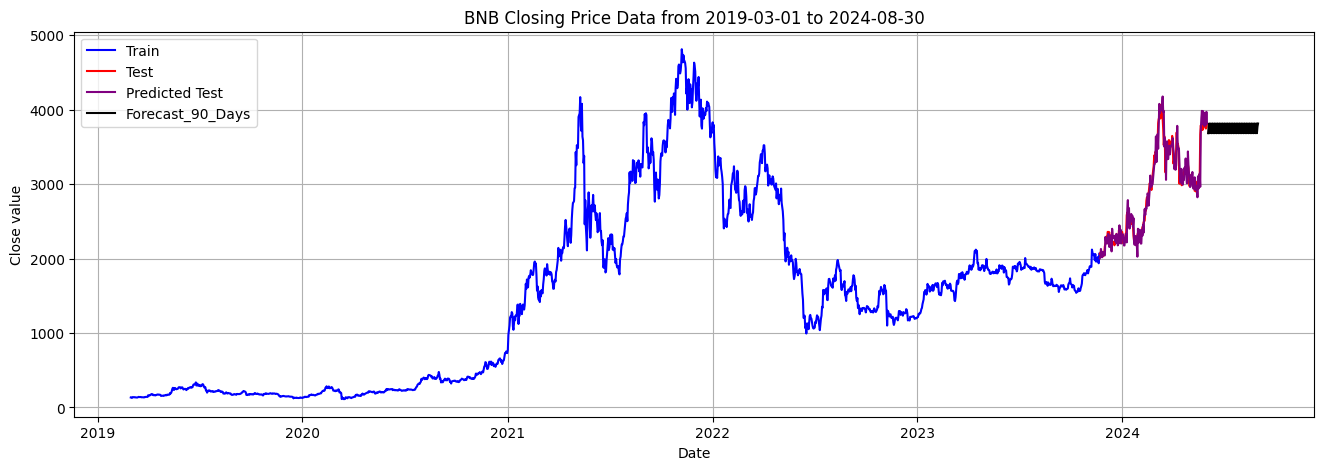

In [23]:
# Vẽ đồ thị cho dự đoán 90 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_90_days, forecast_90_days_inverse, color='black', linestyle='-', label='Forecast_90_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_ETH_90days_91.png')
plt.show()